<a href="https://colab.research.google.com/github/Sidhtang/FINANCIAL-MODEL-using-machine-learning/blob/main/arima_model_for_crypto_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and preprocessing data...


<ipython-input-25-d5416492059d>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')
<ipython-input-25-d5416492059d>:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')


Training data shape: (1812332, 16)
Test data shape: (909616, 16)

Running ARIMA model...


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA (Train) Results:
F1 Score: 0.4885
Accuracy: 0.4996
Confusion Matrix:
 [[472538 474401]
 [432441 432951]]

ARIMA (Test) Results:
F1 Score: 0.0002
Accuracy: 0.5801
Confusion Matrix:
 [[527579     44]
 [381948     44]]


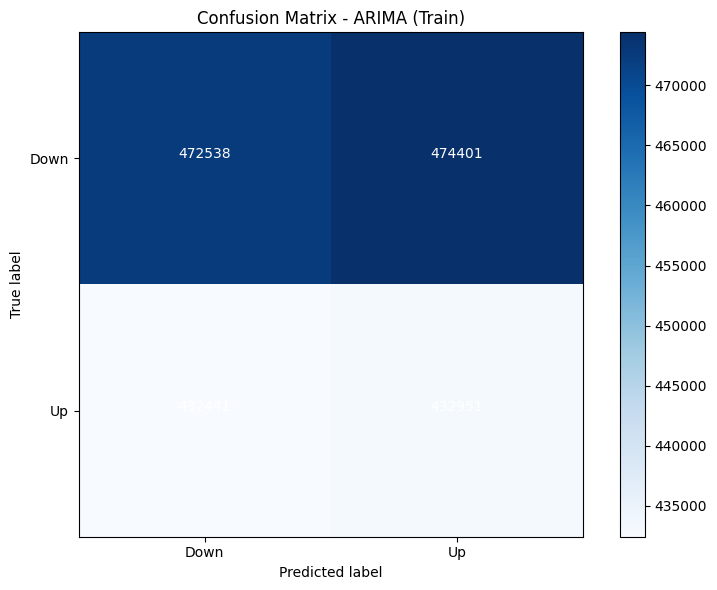

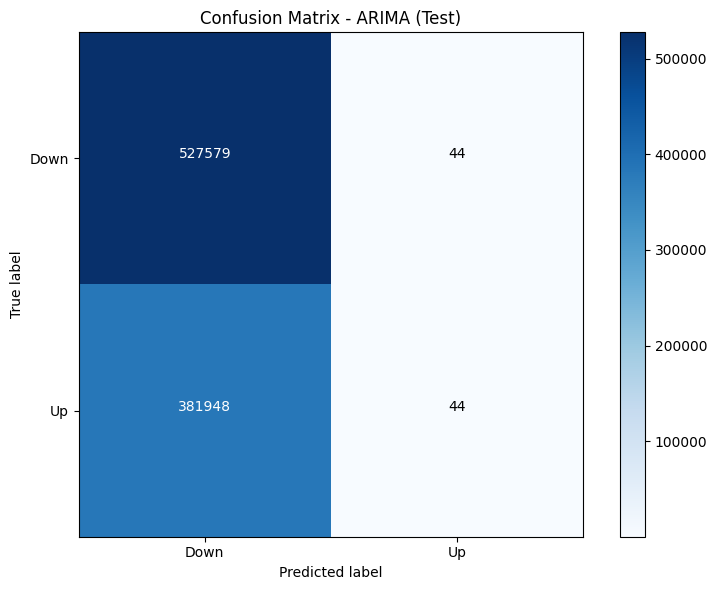

In [25]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

def preprocess_data(df):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.dropna()
    df = df.replace([np.inf, -np.inf], np.nan).dropna()

    # Add technical indicators
    df['SMA_5'] = df['close'].rolling(window=5).mean()
    df['SMA_20'] = df['close'].rolling(window=20).mean()
    df['RSI'] = calculate_rsi(df['close'])
    df['MACD'] = calculate_macd(df['close'])

    # Fill NaN values created by indicators
    df = df.fillna(method='bfill')
    return df

def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(prices, fast=12, slow=26):
    exp1 = prices.ewm(span=fast, adjust=False).mean()
    exp2 = prices.ewm(span=slow, adjust=False).mean()
    return exp1 - exp2

def add_price_direction(df):
    # Ensure we don't create a label for the last row
    df['price_direction'] = np.where(df['close'].shift(-1) > df['close'], 1, 0)
    # Remove the last row since it will have NaN in price_direction
    return df.iloc[:-1].copy()

def run_arima(train_data, test_data, order=(2, 1, 2)):
    # Fit ARIMA model on the training data
    model = ARIMA(train_data, order=order)
    results = model.fit()

    # Generate forecasts for both training and test sets
    train_forecast = results.fittedvalues
    test_forecast = results.forecast(steps=len(test_data))

    # Convert to direction predictions
    train_direction = (np.diff(np.concatenate([[train_data.iloc[0]], train_forecast])) > 0).astype(int)
    test_direction = (np.diff(np.concatenate([[test_data.iloc[0]], test_forecast])) > 0).astype(int)

    # Ensure lengths match
    train_direction = train_direction[:len(train_data)-1]  # Remove last prediction
    test_direction = test_direction[:len(test_data)-1]  # Remove last prediction

    return train_direction, test_direction

def evaluate_model(y_true, y_pred, model_name):
    from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

    f1 = f1_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n{model_name} Results:")
    print(f"F1 Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Confusion Matrix:\n", cm)
    return f1, accuracy, cm

def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Down', 'Up'])
    plt.yticks(tick_marks, ['Down', 'Up'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Add text annotations
    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    train_df = pd.read_csv('/content/train[1].csv')
    test_df = pd.read_csv('/content/test.csv')

    # Preprocess both datasets
    train_df = preprocess_data(train_df)
    test_df = preprocess_data(test_df)

    # Add price direction and remove last row
    train_df = add_price_direction(train_df)
    test_df = add_price_direction(test_df)

    print("Training data shape:", train_df.shape)
    print("Test data shape:", test_df.shape)

    # ARIMA model
    print("\nRunning ARIMA model...")
    arima_train_pred, arima_test_pred = run_arima(
        train_df['close'],
        test_df['close']
    )

    # Evaluate ARIMA results
    arima_train_metrics = evaluate_model(
        train_df['price_direction'].iloc[:len(arima_train_pred)],
        arima_train_pred,
        "ARIMA (Train)"
    )
    arima_test_metrics = evaluate_model(
        test_df['price_direction'].iloc[:len(arima_test_pred)],
        arima_test_pred,
        "ARIMA (Test)"
    )

    # Plot ARIMA confusion matrices
    plot_confusion_matrix(arima_train_metrics[2], "ARIMA (Train)")
    plot_confusion_matrix(arima_test_metrics[2], "ARIMA (Test)")

if __name__ == "__main__":
    main()

In [32]:
import pandas as pd
import numpy as np
import joblib
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA

class PricePredictionModel:
    def __init__(self, arima_order=(2, 1, 2)):
        self.arima_model = None
        self.arima_order = arima_order
        self.feature_columns = ['close', 'SMA_5', 'SMA_20', 'RSI', 'MACD']
        self.last_prices = None

    def save_model(self, path='./models/'):
        """Save trained ARIMA model"""
        try:
            # Create directory if it doesn't exist
            import os
            os.makedirs(path, exist_ok=True)

            # Save ARIMA model and last prices
            model_data = {
                'model': self.arima_model,
                'last_prices': self.last_prices,
                'arima_order': self.arima_order
            }
            joblib.dump(model_data, f'{path}arima_model.pkl')
            print("Model saved successfully!")

        except Exception as e:
            print(f"Error saving model: {e}")

    def load_model(self, path='./models/'):
        """Load trained ARIMA model"""
        try:
            # Load ARIMA model and last prices
            model_data = joblib.load(f'{path}arima_model.pkl')
            self.arima_model = model_data['model']
            self.last_prices = model_data['last_prices']
            self.arima_order = model_data['arima_order']
            print("Model loaded successfully!")

        except Exception as e:
            print(f"Error loading model: {e}")

    def prepare_data(self, df):
        """Prepare data for prediction"""
        df = df.copy()

        if isinstance(df['close'].iloc[0], str):
            df['close'] = df['close'].astype(float)

        # Calculate technical indicators
        df['SMA_5'] = df['close'].rolling(window=5).mean()
        df['SMA_20'] = df['close'].rolling(window=20).mean()

        # Calculate RSI
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Calculate MACD
        exp1 = df['close'].ewm(span=12, adjust=False).mean()
        exp2 = df['close'].ewm(span=26, adjust=False).mean()
        df['MACD'] = exp1 - exp2

        # Forward fill any NaN values
        df = df.fillna(method='ffill')
        df = df.fillna(method='bfill')  # For any remaining NaNs at the start

        return df

    def train(self, df):
        """Train the ARIMA model"""
        try:
            print("Training ARIMA model...")
            prepared_data = self.prepare_data(df)

            # Store last prices for future predictions
            self.last_prices = prepared_data['close'].values[-10:]

            # Fit ARIMA model
            self.arima_model = ARIMA(prepared_data['close'].values, order=self.arima_order)
            self.arima_model = self.arima_model.fit()

            print("Model training completed successfully!")

        except Exception as e:
            print(f"Error training model: {e}")
            raise

    def predict_next_day(self, df):
        """Make prediction for the next day"""
        try:
            if self.arima_model is None:
                raise ValueError("Model needs to be trained first!")

            # Prepare data
            prepared_data = self.prepare_data(df)
            current_price = prepared_data['close'].iloc[-1]

            # Make ARIMA prediction
            forecast = self.arima_model.forecast(steps=1)
            predicted_price = forecast[0] if isinstance(forecast, np.ndarray) else forecast

            # Calculate direction and confidence
            direction = 1 if predicted_price > current_price else 0
            confidence = min(abs(predicted_price - current_price) / current_price, 1)

            prediction = {
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'current_price': float(current_price),
                'predicted_price': float(predicted_price),
                'direction': 'Up' if direction == 1 else 'Down',
                'confidence': float(confidence),
                'predicted_change_pct': float(((predicted_price - current_price) / current_price) * 100)
            }

            return prediction

        except Exception as e:
            print(f"Error making prediction: {e}")
            return None

    def update_model(self, new_price):
        """Update the model with new price data"""
        try:
            if self.arima_model is None:
                raise ValueError("Model needs to be trained first!")

            # Update last prices
            self.last_prices = np.append(self.last_prices[1:], new_price)

            # Retrain model with updated data
            self.arima_model = ARIMA(self.last_prices, order=self.arima_order)
            self.arima_model = self.arima_model.fit()

            print("Model updated successfully!")

        except Exception as e:
            print(f"Error updating model: {e}")

def main():
    """Example usage"""
    # Create sample data
    dates = pd.date_range(start='2024-01-01', end='2024-01-30')
    sample_data = pd.DataFrame({
        'timestamp': dates,
        'close': np.random.randn(30).cumsum() + 100  # Random price data
    })

    try:
        # Initialize model
        model = PricePredictionModel()

        # Train model
        model.train(sample_data)

        # Make prediction
        prediction = model.predict_next_day(sample_data)

        if prediction:
            print("\nPrediction Results:")
            print(f"Timestamp: {prediction['timestamp']}")
            print(f"Current Price: ${prediction['current_price']:.2f}")
            print(f"Predicted Price: ${prediction['predicted_price']:.2f}")
            print(f"Direction: {prediction['direction']}")
            print(f"Confidence: {prediction['confidence']:.2%}")
            print(f"Predicted Change: {prediction['predicted_change_pct']:.2f}%")

            # Save model
            model.save_model()

            # Example of updating with new price
            new_price = prediction['predicted_price'] * (1 + np.random.randn() * 0.01)
            model.update_model(new_price)

        else:
            print("Prediction failed!")

    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    main()

Training ARIMA model...


<ipython-input-32-81dfa9c74cb7>:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-32-81dfa9c74cb7>:71: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')  # For any remaining NaNs at the start


Model training completed successfully!

Prediction Results:
Timestamp: 2024-10-27 07:53:38
Current Price: $105.03
Predicted Price: $105.62
Direction: Up
Confidence: 0.57%
Predicted Change: 0.57%
Model saved successfully!
Model updated successfully!


<ipython-input-32-81dfa9c74cb7>:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')
<ipython-input-32-81dfa9c74cb7>:71: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')  # For any remaining NaNs at the start
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
